<a href="https://colab.research.google.com/github/ihabiba/DataMining-OnlineLearning/blob/main/Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import seaborn as sns

#------------------------------------
# READS DATA SET AVOCADO.CSV
#-----------------------------------
df = pd.read_csv("personalized_learning_dataset.csv")
df.head


<bound method NDFrame.head of      Student_ID  Age  Gender Education_Level       Course_Name  \
0        S00001   15  Female     High School  Machine Learning   
1        S00002   49    Male   Undergraduate     Python Basics   
2        S00003   20  Female   Undergraduate     Python Basics   
3        S00004   37  Female   Undergraduate      Data Science   
4        S00005   34  Female    Postgraduate     Python Basics   
...         ...  ...     ...             ...               ...   
9995     S09996   26  Female   Undergraduate  Machine Learning   
9996     S09997   37    Male    Postgraduate  Machine Learning   
9997     S09998   40  Female    Postgraduate  Machine Learning   
9998     S09999   44    Male     High School     Python Basics   
9999     S10000   39  Female   Undergraduate  Machine Learning   

      Time_Spent_on_Videos  Quiz_Attempts  Quiz_Scores  Forum_Participation  \
0                      171              4           67                    2   
1                      156              4           64                    0   
2                      217              2           55                    2   
3                      489              1           65                   43   
4                      496              3           59                   34   
...                    ...            ...          ...                  ...   
9995                   162              2           87                   27   
9996                   447              2           39                   10   
9997                   105              4           50                   23   
9998                   245              2           84                   39   
9999                   171              2           88                    8   

      Assignment_Completion_Rate Engagement_Level  Final_Exam_Score  \
0                             89           Medium                51   
1                             94           Medium                92   
2                             67           Medium                45   
3                             60             High                59   
4                             88           Medium                93   
...                          ...              ...               ...   
9995                          73           Medium                68   
9996                          68           Medium                46   
9997                          41             High                64   
9998                          85           Medium                38   
9999                          69           Medium                97   

       Learning_Style  Feedback_Score Dropout_Likelihood  
0              Visual               1                 No  
1     Reading/Writing               5                 No  
2     Reading/Writing               1                 No  
3              Visual               4                 No  
4              Visual               3                 No  
...               ...             ...                ...  
9995      Kinesthetic               2                 No  
9996  Reading/Writing               1                Yes  
9997           Visual               1                 No  
9998           Visual               2                 No  
9999           Visual               2                 No  

[10000 rows x 15 columns]>

# Preprocessing Data

In [2]:
df.shape        # Rows & columns
df.info()       # Data types & nulls
df.describe()   # Stats (mean, std, min, max, quartiles)
print("Missing values per column:"), df.isnull().sum()      # Missing values check
print("\nNumber of duplicate rows:", df.duplicated().sum()) # Check for duplicates

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Student_ID                  10000 non-null  object
 1   Age                         10000 non-null  int64 
 2   Gender                      10000 non-null  object
 3   Education_Level             10000 non-null  object
 4   Course_Name                 10000 non-null  object
 5   Time_Spent_on_Videos        10000 non-null  int64 
 6   Quiz_Attempts               10000 non-null  int64 
 7   Quiz_Scores                 10000 non-null  int64 
 8   Forum_Participation         10000 non-null  int64 
 9   Assignment_Completion_Rate  10000 non-null  int64 
 10  Engagement_Level            10000 non-null  object
 11  Final_Exam_Score            10000 non-null  int64 
 12  Learning_Style              10000 non-null  object
 13  Feedback_Score              10000 non-null  int

In [3]:
# Drop ID
df = df.drop(columns=['Student_ID'])

# Label Encode binary categorical features
label_cols = ['Gender', 'Dropout_Likelihood']
for col in label_cols:
 le = LabelEncoder()
df[col] = le.fit_transform(df[col])

# One-Hot Encode multi-category features
df = pd.get_dummies(df, columns=['Education_Level', 'Course_Name',
                                 'Engagement_Level', 'Learning_Style'],
                drop_first=True)

# Now only numeric columns remain
numeric_df = df.select_dtypes(include=[np.number]).dropna()
print("Numeric dataset shape:", numeric_df.shape)
print(numeric_df.head())

Numeric dataset shape: (10000, 9)
   Age  Time_Spent_on_Videos  Quiz_Attempts  Quiz_Scores  Forum_Participation  \
0   15                   171              4           67                    2   
1   49                   156              4           64                    0   
2   20                   217              2           55                    2   
3   37                   489              1           65                   43   
4   34                   496              3           59                   34   

   Assignment_Completion_Rate  Final_Exam_Score  Feedback_Score  \
0                          89                51               1   
1                          94                92               5   
2                          67                45               1   
3                          60                59               4   
4                          88                93               3   

   Dropout_Likelihood  
0                   0  
1                   0  
2   

# Scalling

In [4]:
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_df)

# Apply the DBSCAN, LOF, Isolation Forest

In [5]:
# Apply Isolation Forest
iforest = IsolationForest(contamination=0.05, random_state=42)
iforest.fit(X_scaled)
if_labels = iforest.predict(X_scaled)

# IF: -1 = anomaly, 1 = normal
df["IF_Anomaly"] = if_labels == -1

In [6]:
# Apply LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)  # adjust contamination
lof_labels = lof.fit_predict(X_scaled)

# LOF: -1 = anomaly, 1 = normal
df["LOF_Anomaly"] = lof_labels == -1

In [7]:
# Apply DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)  # you can tune eps
dbscan_labels = dbscan.fit_predict(X_scaled)

# -1 means anomaly
df["DBSCAN_Anomaly"] = dbscan_labels == -1


# Compare them

In [8]:
print(df[["DBSCAN_Anomaly", "LOF_Anomaly", "IF_Anomaly"]].sum())

DBSCAN_Anomaly    379
LOF_Anomaly       500
IF_Anomaly        500
dtype: int64


# Final Summarize using DBSCAN,LOF,Isolation Forest

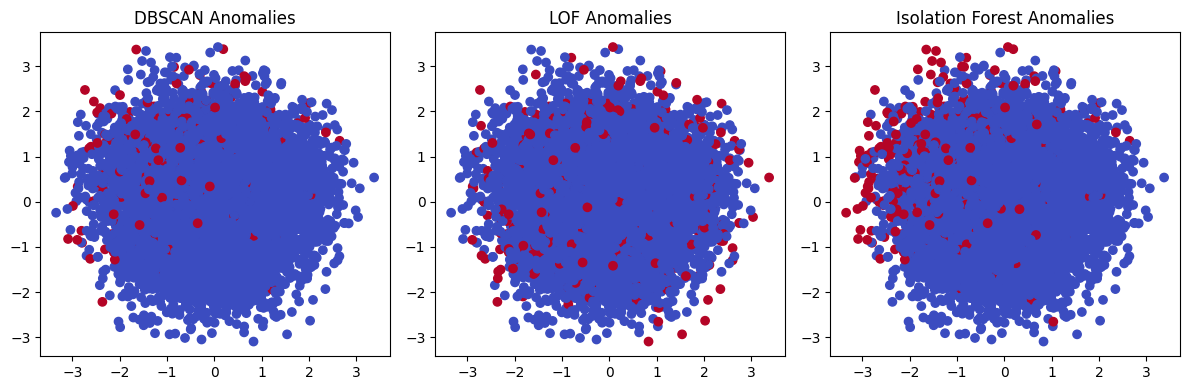

In [13]:

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12,4))

# DBSCAN
plt.subplot(1,3,1)
plt.scatter(X_pca[:,0], X_pca[:,1], c=df["DBSCAN_Anomaly"], cmap="coolwarm")
plt.title("DBSCAN Anomalies")

# LOF
plt.subplot(1,3,2)
plt.scatter(X_pca[:,0], X_pca[:,1], c=df["LOF_Anomaly"], cmap="coolwarm")
plt.title("LOF Anomalies")

# Isolation Forest
plt.subplot(1,3,3)
plt.scatter(X_pca[:,0], X_pca[:,1], c=df["IF_Anomaly"], cmap="coolwarm")
plt.title("Isolation Forest Anomalies")

plt.tight_layout()
plt.savefig(os.path.join(assets_dir, 'anomaly_detection_pca_comparison.png'))
plt.show()

/tmp/ipython-input-2816625709.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=algo, y=counts, palette='viridis')


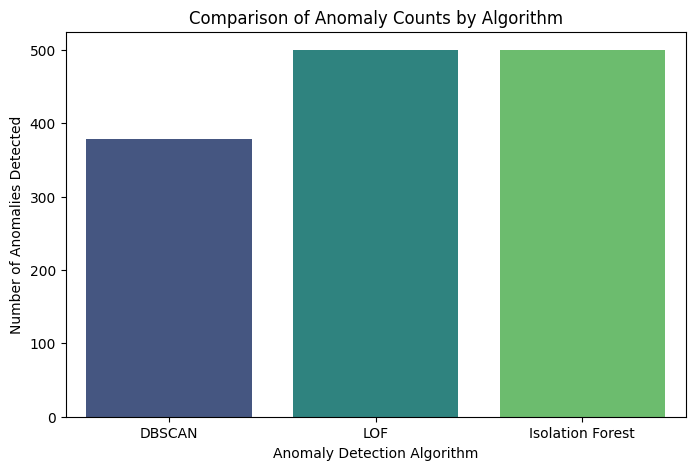

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

algo = ["DBSCAN", "LOF", "Isolation Forest"]
counts = df[["DBSCAN_Anomaly", "LOF_Anomaly", "IF_Anomaly"]].sum().tolist()

plt.figure(figsize=(8, 5))
sns.barplot(x=algo, y=counts, palette='viridis')
plt.title('Comparison of Anomaly Counts by Algorithm')
plt.xlabel('Anomaly Detection Algorithm')
plt.ylabel('Number of Anomalies Detected')
plt.savefig(os.path.join(assets_dir, 'anomaly_counts_bar_chart.png'))
plt.show()

In [12]:
import os

assets_dir = 'assets'

if not os.path.exists(assets_dir):
    os.makedirs(assets_dir)
    print(f"Directory '{assets_dir}' created successfully.")
else:
    print(f"Directory '{assets_dir}' already exists.")

Directory 'assets' created successfully.


In [15]:
import os

assets_dir = 'assets'

# Check if the assets directory exists before zipping
if os.path.exists(assets_dir):
    zip_command = f"zip -r {assets_dir}.zip {assets_dir}"
    print(f"Executing: {zip_command}")
    os.system(zip_command)
    print(f"Folder '{assets_dir}' has been zipped to '{assets_dir}.zip'.")
else:
    print(f"Directory '{assets_dir}' does not exist. No folder to zip.")

Executing: zip -r assets.zip assets
Folder 'assets' has been zipped to 'assets.zip'.
